<a href="https://colab.research.google.com/github/MayankJ03/Smart_Traffic_Condition_Predictor/blob/main/Smart_Traffic_Condition_Predictor_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ✅ Step 1: Install required packages
!pip install -q pandas scikit-learn matplotlib requests


In [12]:
# ✅ Step 2: Import all libraries
import pandas as pd
import numpy as np
import datetime
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display


In [13]:
# Upload Metro_Interstate_Traffic_Volume.csv from your PC
from google.colab import files
uploaded = files.upload()


Saving Metro_Interstate_Traffic_Volume.csv to Metro_Interstate_Traffic_Volume.csv


In [14]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

# Extract datetime features
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek


In [22]:
np.random.seed(42)
df['distance_km'] = np.random.uniform(5, 25, len(df))
df['avg_speed'] = np.random.uniform(10, 60, len(df))
df['travel_time_min'] = df['distance_km'] / df['avg_speed'] * 60

def custom_label(speed):
    if speed < 20:
        return 0
    elif speed > 45:
        return 1
    else:
        return np.random.choice([0, 1])

df['favorable'] = df['avg_speed'].apply(custom_label)


In [23]:
# Simulated weather features
df['temp'] = 295.0
df['rain_1h'] = 0.0
df['snow_1h'] = 0.0
df['clouds_all'] = 20.0

# Train ML model
features = ['hour', 'day_of_week', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'avg_speed']
target = 'favorable'

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("✅ Accuracy:", accuracy_score(y_test, rf.predict(X_test)))
print(classification_report(y_test, rf.predict(X_test)))


✅ Accuracy: 0.7516855098018878
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      4346
           1       0.77      0.77      0.77      5295

    accuracy                           0.75      9641
   macro avg       0.75      0.75      0.75      9641
weighted avg       0.75      0.75      0.75      9641



In [24]:
def show_favorability_gauge(score):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    theta = np.linspace(np.pi, 0, 100)
    r = 0.4
    x = 0.5 + r * np.cos(theta)
    y = 0.1 + r * np.sin(theta)
    ax.plot(x, y, color='gray', linewidth=10)

    angle = np.pi * (1 - score)
    x_needle = 0.5 + r * np.cos(angle)
    y_needle = 0.1 + r * np.sin(angle)
    ax.plot([0.5, x_needle], [0.1, y_needle], color='red', linewidth=3)

    ax.text(0.5, 0.85, "Favorability Index", ha='center', fontsize=14)
    ax.text(0.1, 0.0, "0 (Bad)", ha='center')
    ax.text(0.9, 0.0, "1 (Good)", ha='center')
    ax.text(0.5, 0.0, f"{score:.2f}", ha='center', fontsize=12, fontweight='bold')
    plt.show()


In [25]:
def get_osrm_data_and_predict(origin, destination, model):
    # Get route info from OSRM
    url = f"http://router.project-osrm.org/route/v1/driving/{origin[1]},{origin[0]};{destination[1]},{destination[0]}?overview=false"
    response = requests.get(url)
    data = response.json()

    if 'routes' not in data:
        print("❌ No route found.")
        return

    travel_time = data['routes'][0]['duration'] / 60
    distance = data['routes'][0]['distance'] / 1000
    avg_speed = distance / (travel_time / 60)

    now = datetime.datetime.now()
    hour = now.hour
    day_of_week = now.weekday()

    # Simulated weather features
    temp = 295.0
    rain = 0.0
    snow = 0.0
    clouds = 20.0

    features = {
        "hour": hour,
        "day_of_week": day_of_week,
        "temp": temp,
        "rain_1h": rain,
        "snow_1h": snow,
        "clouds_all": clouds,
        "avg_speed": avg_speed
    }

    input_df = pd.DataFrame([features])
    prediction = model.predict(input_df)[0]
    proba = model.predict_proba(input_df)[0][1]

    print("🔍 Input Features:")
    for k, v in features.items():
        print(f"{k}: {v:.2f}")

    print(f"\nPrediction: {'✅ Favorable' if prediction == 1 else '⚠️ Unfavorable'}")
    print(f"Favorability Index: {proba:.2f}")
    print(f"Distance: {distance:.2f} km")
    print(f"Travel Time: {travel_time:.2f} min")

    show_favorability_gauge(proba)


🔍 Input Features:
hour: 18.00
day_of_week: 3.00
temp: 295.00
rain_1h: 0.00
snow_1h: 0.00
clouds_all: 20.00
avg_speed: 58.88

Prediction: ✅ Favorable
Favorability Index: 1.00
Distance: 17.24 km
Travel Time: 17.57 min


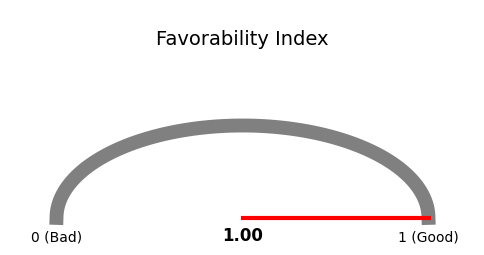

In [26]:
# ✅ Pasadena → LA Test Route
origin = (34.1478, -118.1445)       # Pasadena City Hall
destination = (34.0537, -118.2428)  # LA City Hall

get_osrm_data_and_predict(origin, destination, rf)
